# NN-Session-1 MLX Solution: Binary Classification

This notebook provides an Apple Silicon optimized solution for the NN-session-1 exercises using the MLX framework.
It demonstrates how to build a simple neural network for binary classification.

## 1. Setup and Library Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn

# Machine learning tools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)
mx.random.seed(42)

print(f"MLX version: {mx.__version__}")

MLX version: 0.30.0


## 2. Loading Preprocessed Sherlock Dataset

In [2]:
# Load preprocessed features and labels
try:
    df2_features = pd.read_csv('sherlock/2apps_4f/sherlock_2apps_features.csv')
    df2_labels = pd.read_csv('sherlock/2apps_4f/sherlock_2apps_labels.csv')
except FileNotFoundError:
    # Attempt to look in the parent directory if running from subdirectory
    df2_features = pd.read_csv('../sherlock/2apps_4f/sherlock_2apps_features.csv')
    df2_labels = pd.read_csv('../sherlock/2apps_4f/sherlock_2apps_labels.csv')

print(f"Features shape: {df2_features.shape}")
print(f"Labels shape: {df2_labels.shape}")
print(f"\nFeatures: {df2_features.columns.tolist()}")
print(f"\nFirst 5 rows of features:")
print(df2_features.head())
print(f"\nLabel distribution:")
print(df2_labels.value_counts())

Features shape: (612114, 4)
Labels shape: (612114, 1)

Features: ['cutime', 'num_threads', 'otherPrivateDirty', 'priority']

First 5 rows of features:
     cutime  num_threads  otherPrivateDirty  priority
0 -0.429029    -1.300898          -0.780597  0.246368
1 -0.429029     0.222698          -0.688933  0.246368
2 -0.429029    -0.292636          -0.321111  0.246368
3 -0.429029    -1.300898          -0.785560  0.246368
4 -0.429029     0.222698          -0.687036  0.246368

Label distribution:
ApplicationName
0                  379054
1                  233060
Name: count, dtype: int64


In [3]:
# SOLUTION: Split data into training and testing sets
train_F, test_F, train_L, test_L = train_test_split(df2_features, df2_labels, test_size=0.2, random_state=42)

print(f"Training set: {train_F.shape}")
print(f"Test set: {test_F.shape}")
print(f"\nTraining labels distribution:")
print(train_L.value_counts())
print(f"\nTest labels distribution:")
print(test_L.value_counts())

# Convert to MLX arrays
def to_mlx(x):
    return mx.array(x.values.astype(np.float32))

train_F_mx = to_mlx(train_F)
test_F_mx = to_mlx(test_F)
train_L_mx = to_mlx(train_L)
test_L_mx = to_mlx(test_L)

Training set: (489691, 4)
Test set: (122423, 4)

Training labels distribution:
ApplicationName
0                  303142
1                  186549
Name: count, dtype: int64

Test labels distribution:
ApplicationName
0                  75912
1                  46511
Name: count, dtype: int64


## 3. Building a One-Neuron Binary Classifier with MLX

In [4]:
class MLPBinary(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # A single neuron is just a Linear layer with output dim 1
        self.layer1 = nn.Linear(input_dim, 1)

    def __call__(self, x):
        x = self.layer1(x)
        return mx.sigmoid(x)

# Initialize model
input_dim = train_F.shape[1]
model = MLPBinary(input_dim)
mx.eval(model.parameters())

print("Model initialized!")
print(model)

Model initialized!
MLPBinary(
  (layer1): Linear(input_dims=4, output_dims=1, bias=True)
)


## 4. Training the Model using MLX

In [5]:
def loss_fn(model, X, y):
    # Binary Cross Entropy Loss
    p = model(X)
    # Add epsilon for numerical stability
    eps = 1e-7
    loss = - (y * mx.log(p + eps) + (1 - y) * mx.log(1 - p + eps))
    return mx.mean(loss)

# Hyperparameters
learning_rate = 0.0003
num_epochs = 5 # Reduced for verification speed from 20
batch_size = 32

optimizer = optim.Adam(learning_rate=learning_rate)

def train_step(model, optimizer, X, y):
    loss, grads = nn.value_and_grad(model, loss_fn)(model, X, y)
    optimizer.update(model, grads)
    return loss

# Metric lists
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

print("Training the one-neuron model with MLX...")
print("="*60)

num_samples = train_F_mx.shape[0]
num_batches = num_samples // batch_size

for epoch in range(num_epochs):
    # Shuffle indices
    perm = mx.random.permutation(num_samples)
    epoch_loss = 0.0
    
    for i in range(num_batches):
        ids = perm[i * batch_size : (i + 1) * batch_size]
        X_batch = train_F_mx[ids]
        y_batch = train_L_mx[ids]
        
        batch_loss = train_step(model, optimizer, X_batch, y_batch)
        epoch_loss += batch_loss.item()
        
        # For performance, we can eval the state occasionally or at end of batch
        mx.eval(model.parameters(), optimizer.state)

    # Calculate metrics
    avg_train_loss = epoch_loss / num_batches
    
    # Validation Loop (no grad needed)
    val_pred = model(test_F_mx)
    val_loss = -mx.mean(test_L_mx * mx.log(val_pred + 1e-7) + (1 - test_L_mx) * mx.log(1 - val_pred + 1e-7))
    
    # Accuracy
    train_pred = model(train_F_mx)
    train_acc = mx.mean((train_pred > 0.5) == train_L_mx).item()
    val_acc = mx.mean((val_pred > 0.5) == test_L_mx).item()
    
    history['loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss.item())
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_train_loss:.4f} - accuracy: {train_acc:.4f} - val_loss: {val_loss.item():.4f} - val_accuracy: {val_acc:.4f}")

print("="*60)
print("Training completed!")

Training the one-neuron model with MLX...
Epoch 1/5 - loss: 0.4153 - accuracy: 0.8478 - val_loss: 0.3590 - val_accuracy: 0.8484
Epoch 2/5 - loss: 0.3538 - accuracy: 0.8483 - val_loss: 0.3506 - val_accuracy: 0.8490
Epoch 3/5 - loss: 0.3494 - accuracy: 0.8492 - val_loss: 0.3484 - val_accuracy: 0.8501
Epoch 4/5 - loss: 0.3480 - accuracy: 0.8495 - val_loss: 0.3474 - val_accuracy: 0.8502
Epoch 5/5 - loss: 0.3472 - accuracy: 0.8495 - val_loss: 0.3468 - val_accuracy: 0.8504
Training completed!


## 5. Analyzing Training History

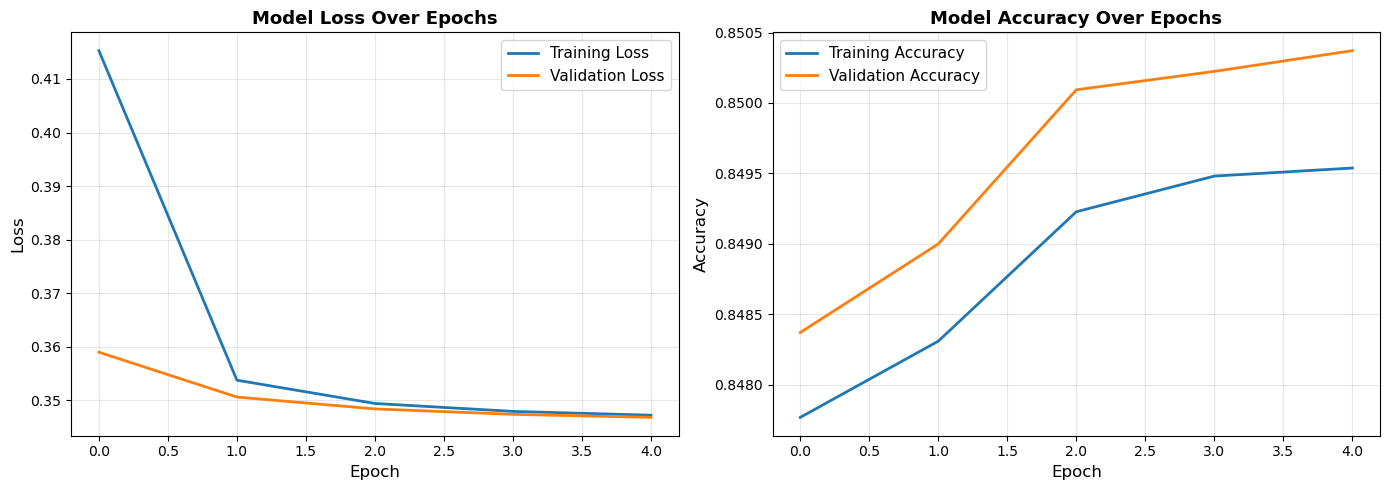


Training History Summary:
Initial Training Loss: 0.4153
Final Training Loss: 0.3472
Initial Validation Loss: 0.3590
Final Validation Loss: 0.3468

Initial Training Accuracy: 0.8478
Final Training Accuracy: 0.8495
Initial Validation Accuracy: 0.8484
Final Validation Accuracy: 0.8504


In [6]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model Loss Over Epochs', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Model Accuracy Over Epochs', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTraining History Summary:")
print(f"Initial Training Loss: {history['loss'][0]:.4f}")
print(f"Final Training Loss: {history['loss'][-1]:.4f}")
print(f"Initial Validation Loss: {history['val_loss'][0]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"\nInitial Training Accuracy: {history['accuracy'][0]:.4f}")
print(f"Final Training Accuracy: {history['accuracy'][-1]:.4f}")
print(f"Initial Validation Accuracy: {history['val_accuracy'][0]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

## 6. Model Evaluation

In [7]:
# SOLUTION: Evaluate MLX model
print("\n" + "="*60)
print("MLX ONE-NEURON MODEL EVALUATION")
print("="*60)

test_pred_raw = model(test_F_mx)
test_loss = -mx.mean(test_L_mx * mx.log(test_pred_raw + 1e-7) + (1 - test_L_mx) * mx.log(1 - test_pred_raw + 1e-7)).item()
test_accuracy = mx.mean((test_pred_raw > 0.5) == test_L_mx).item()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions (back to numpy/python for sklearn metrics)
test_pred_mlx = np.array((test_pred_raw > 0.5).astype(mx.int32)).flatten()
test_L_np = np.array(test_L_mx).flatten()

print(f"\nConfusion Matrix:")
print(confusion_matrix(test_L_np, test_pred_mlx))


MLX ONE-NEURON MODEL EVALUATION
Test Loss: 0.3468
Test Accuracy: 0.8504

Confusion Matrix:
[[73889  2023]
 [16295 30216]]


## 7. Comparison with Traditional ML Models

In [8]:
# SOLUTION: Helper function for model evaluation
def model_evaluate(model, test_F, test_L, model_name=""):
    """
    Evaluate a scikit-learn model.
    """
    test_L_pred = model.predict(test_F)
    acc = accuracy_score(test_L, test_L_pred)
    cm = confusion_matrix(test_L, test_L_pred)
    
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Confusion Matrix:")
    print(cm)
    
    return acc, cm

In [9]:
# SOLUTION: Train Decision Tree model
print("\n" + "="*60)
print("DECISION TREE MODEL")
print("="*60)

model_dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=8, random_state=42)
model_dtc.fit(train_F, train_L)

acc_dtc, cm_dtc = model_evaluate(model_dtc, test_F, test_L, "Decision Tree")


DECISION TREE MODEL

Model: Decision Tree
Accuracy: 0.9875
Confusion Matrix:
[[75348   564]
 [  962 45549]]


In [10]:
# SOLUTION: Train Logistic Regression model
print("\n" + "="*60)
print("LOGISTIC REGRESSION MODEL")
print("="*60)

model_lr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
model_lr.fit(train_F, train_L)

acc_lr, cm_lr = model_evaluate(model_lr, test_F, test_L, "Logistic Regression")


LOGISTIC REGRESSION MODEL


/Users/fiery/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model: Logistic Regression
Accuracy: 0.8503
Confusion Matrix:
[[73883  2029]
 [16294 30217]]


## 8. Results Comparison

In [11]:
# SOLUTION: Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['One-Neuron NN (MLX)', 'Decision Tree', 'Logistic Regression'],
    'Test Accuracy': [test_accuracy, acc_dtc, acc_lr]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Find best model
best_model_idx = comparison_df['Test Accuracy'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Test Accuracy']

print(f"\nBest Model: {best_model}")
print(f"Best Accuracy: {best_accuracy:.4f}")


MODEL COMPARISON
              Model  Test Accuracy
One-Neuron NN (MLX)       0.850371
      Decision Tree       0.987535
Logistic Regression       0.850330

Best Model: Decision Tree
Best Accuracy: 0.9875


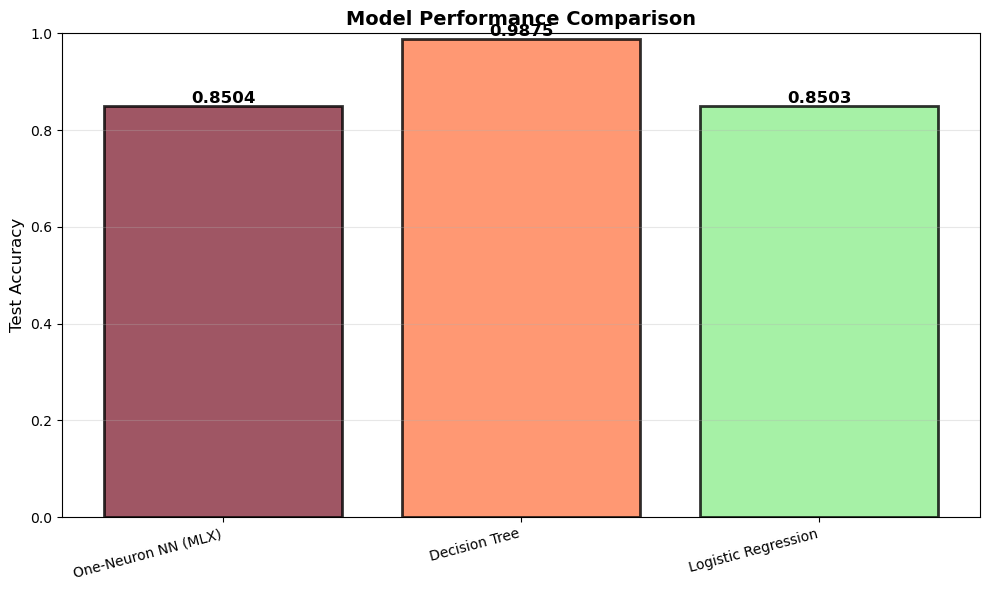

In [12]:
# SOLUTION: Visualize model comparison
fig, ax = plt.subplots(figsize=(10, 6))

models = comparison_df['Model']
accuracies = comparison_df['Test Accuracy']
colors = ['#872c3d', 'coral', 'lightgreen'] # Using the user's preferred reddish tint for the MLX model for flair

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=2, alpha=0.8)

ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()